*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 17 - Generative Adversarial Networks for Synthesizing New Data (Part 2/2)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-05 

numpy 1.17.2
scipy 1.2.1
matplotlib 3.1.0
tensorflow 2.0.0
tensorflow_datasets 1.3.0


In [2]:
from IPython.display import Image
%matplotlib inline

# Improving the quality of synthesized images using a convolutional and Wasserstein GAN

## Transposed convolution

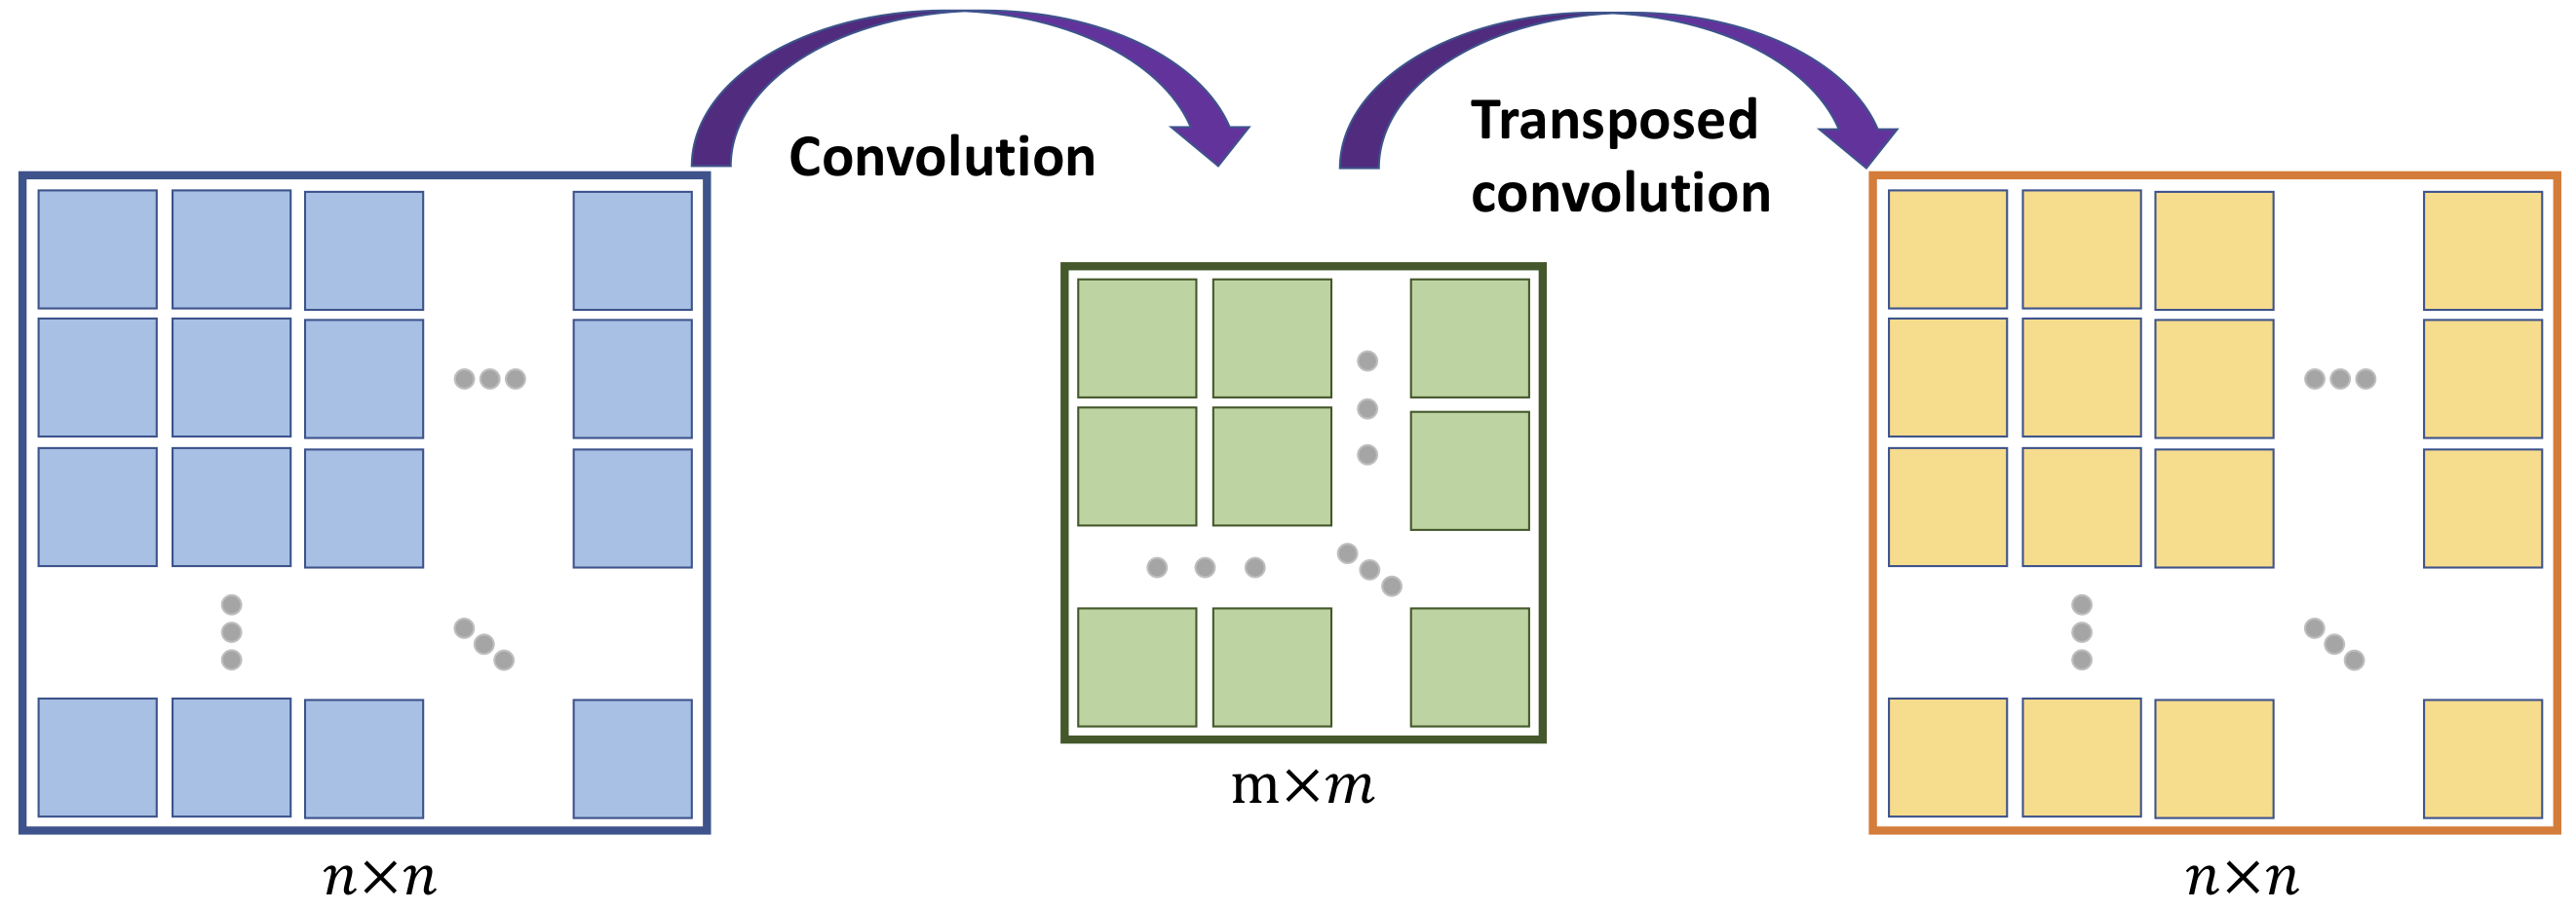

In [3]:
Image(filename='images/17_09.png', width=700)

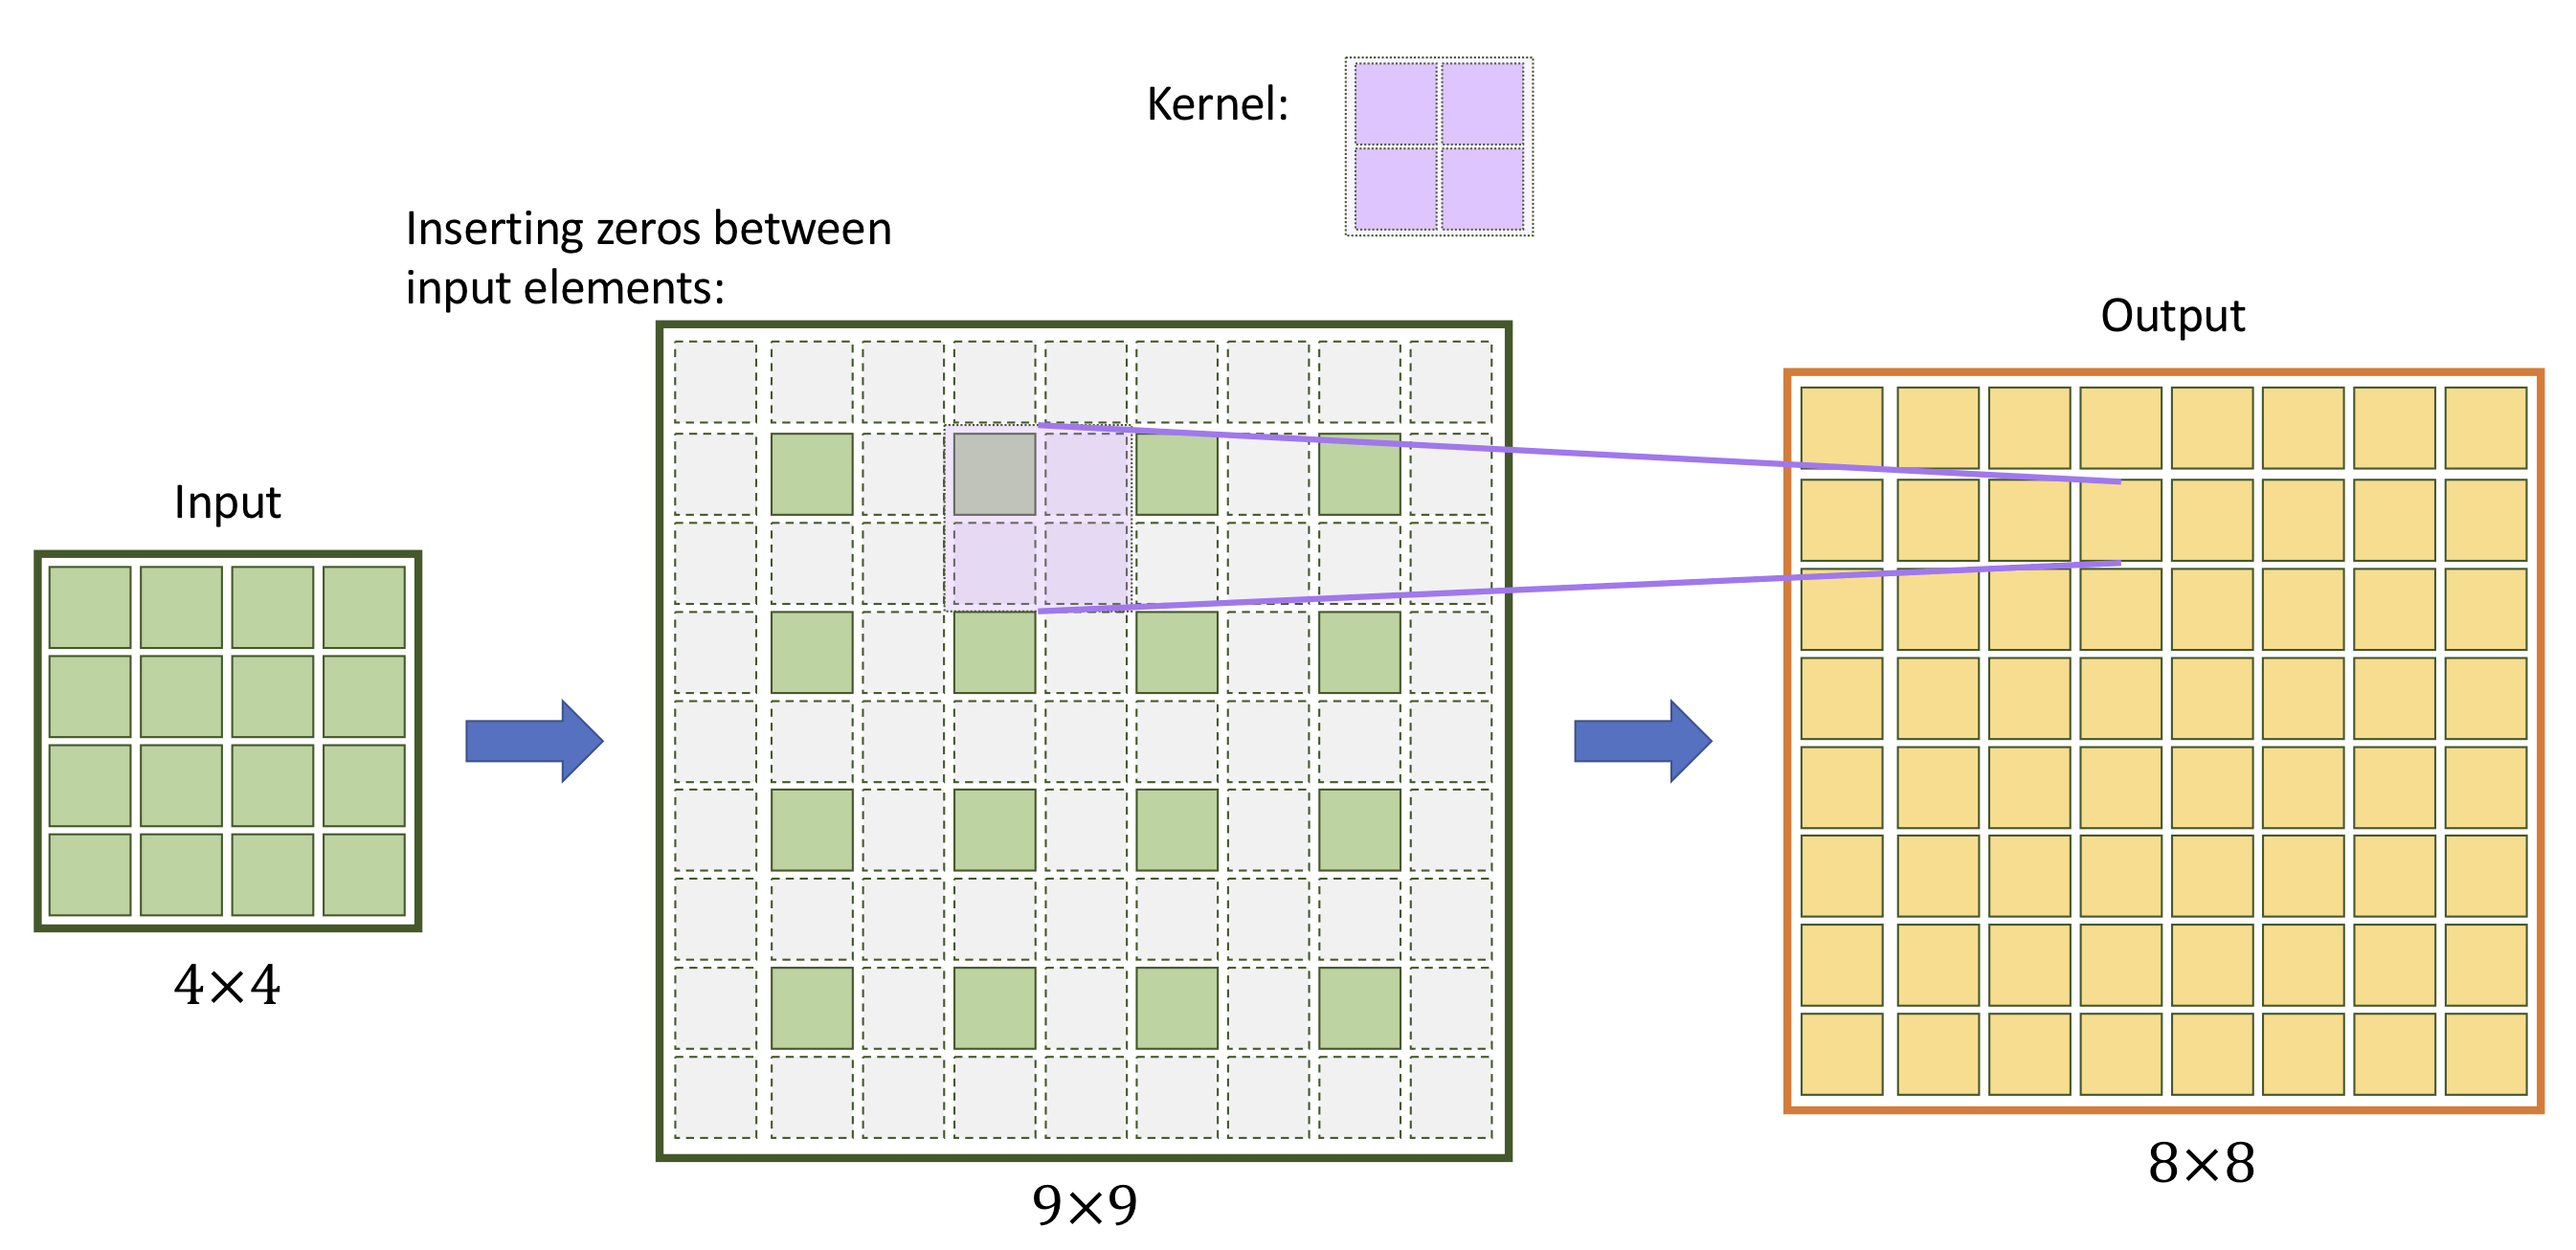

In [4]:
Image(filename='images/17_10.png', width=700)

## Batch normalization

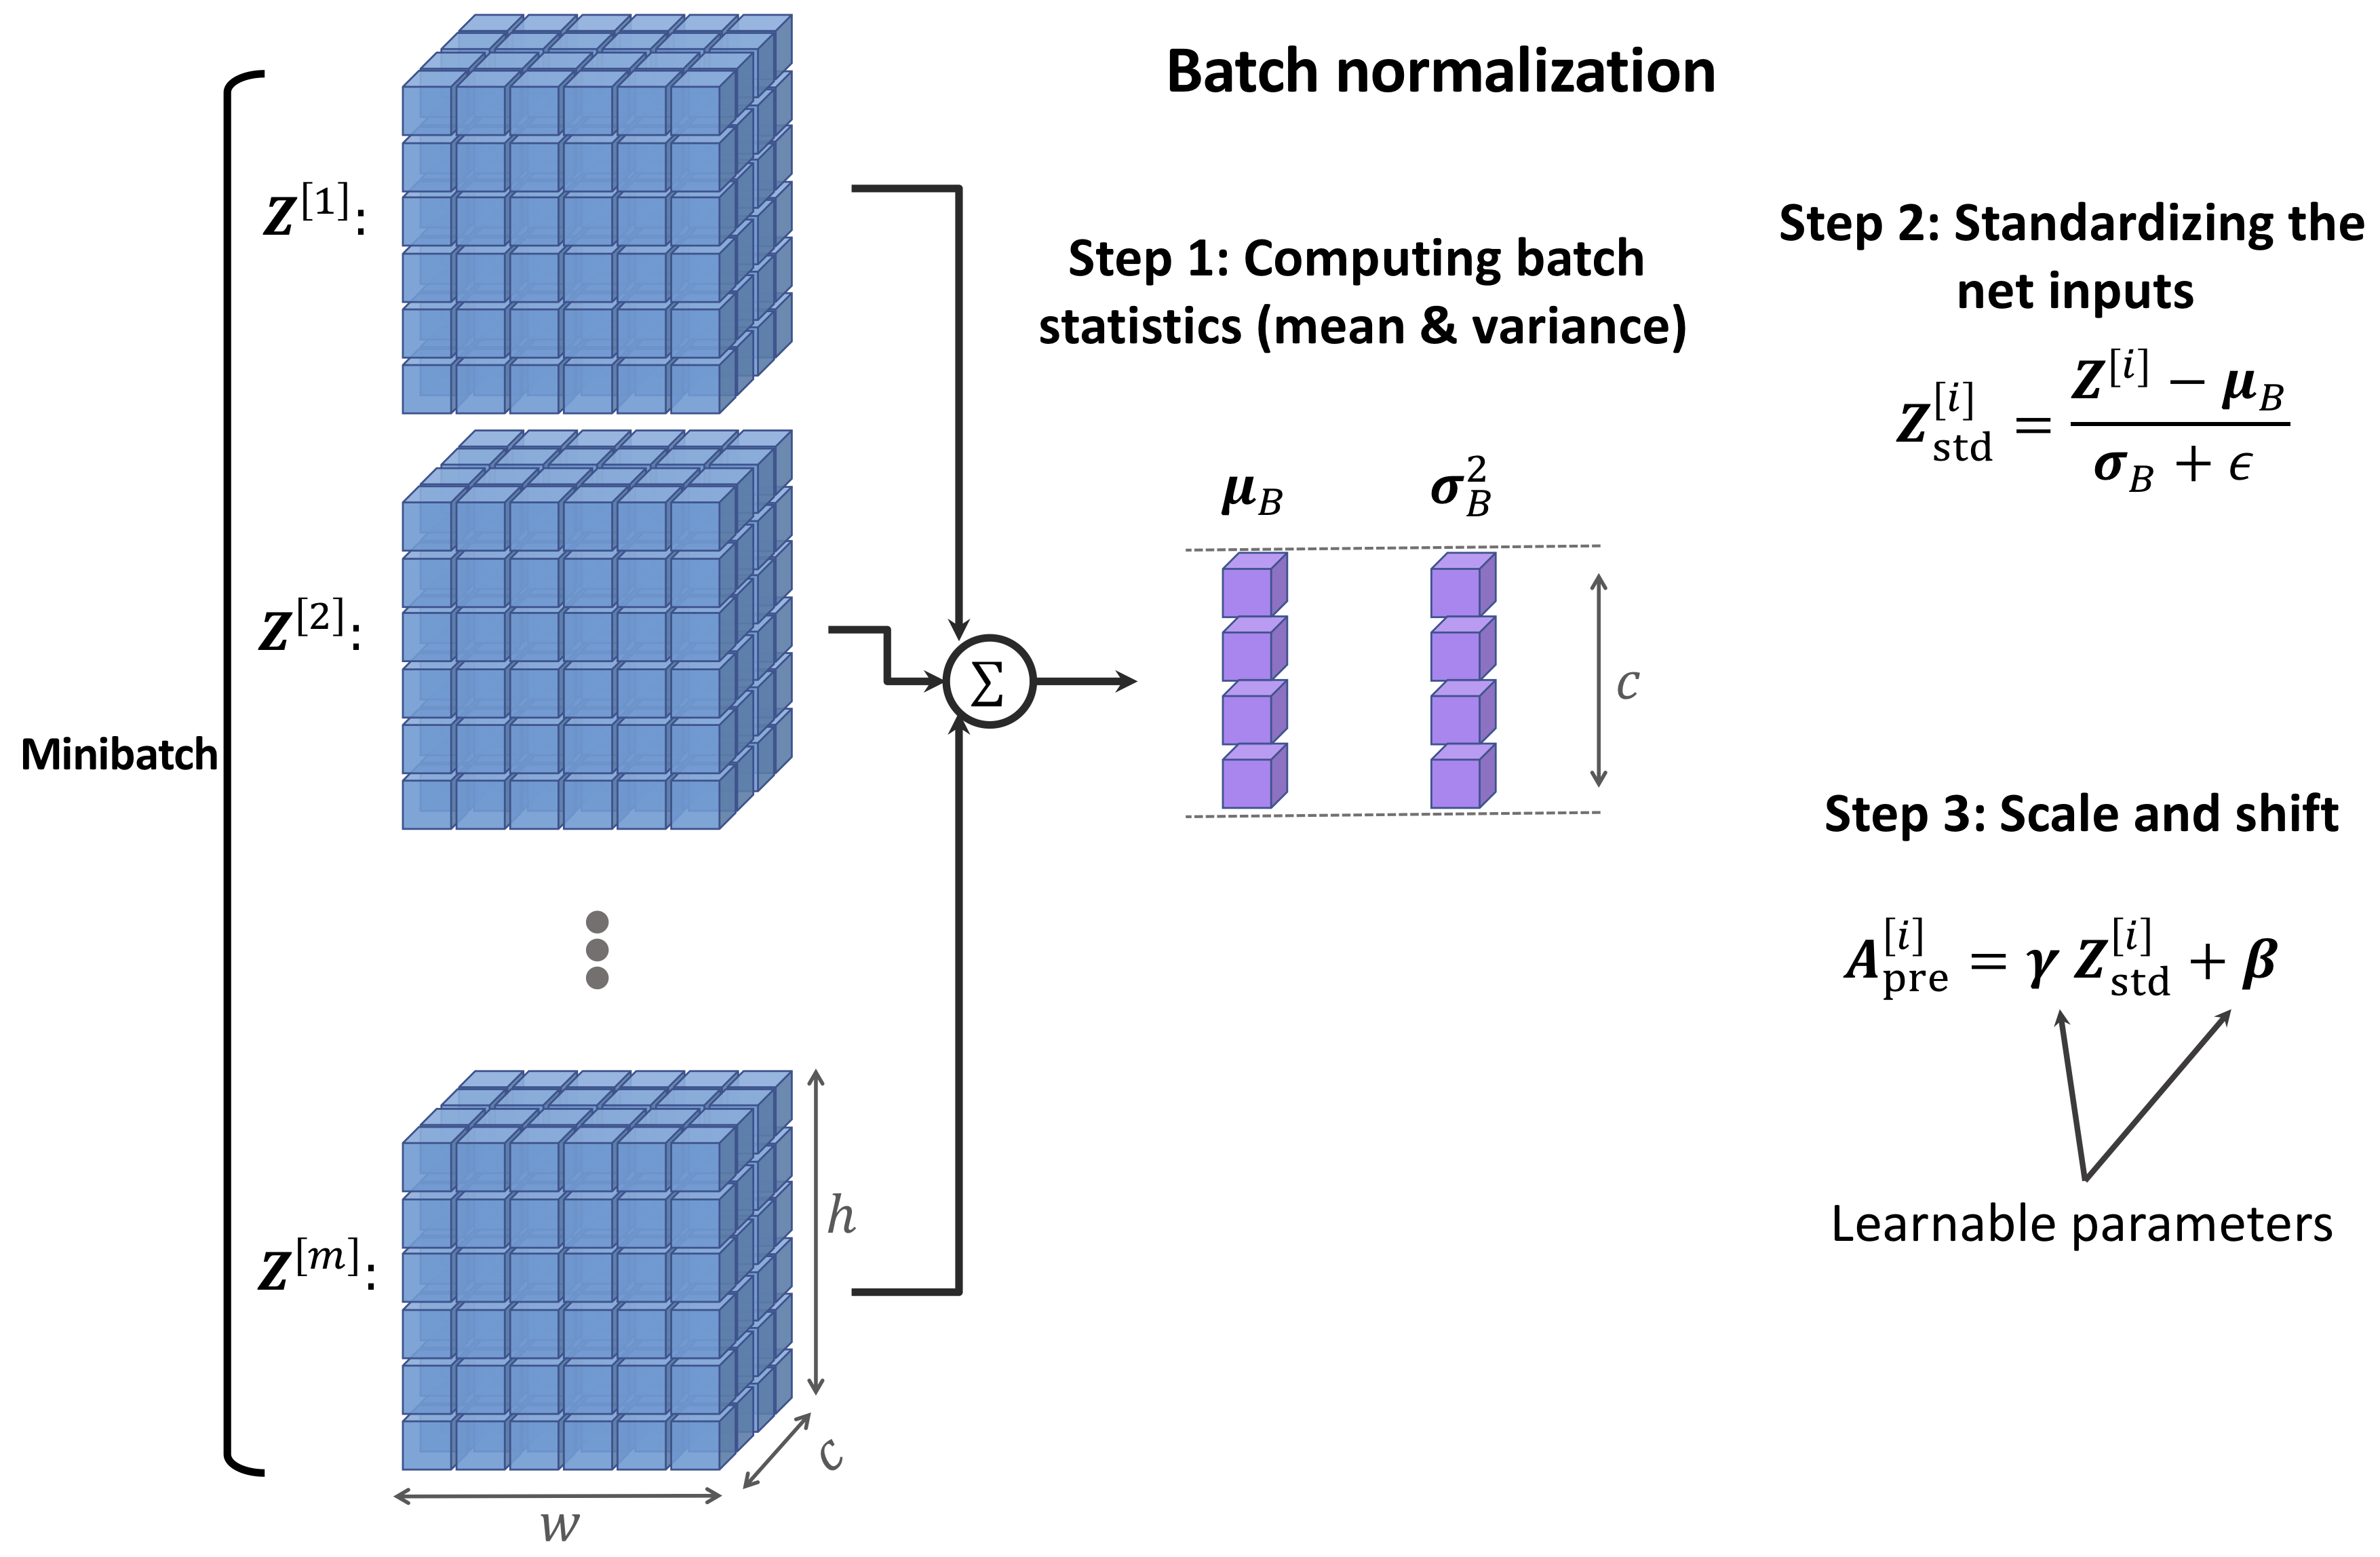

In [5]:
Image(filename='images/17_11.png', width=700)

## Implementing the generator and discriminator

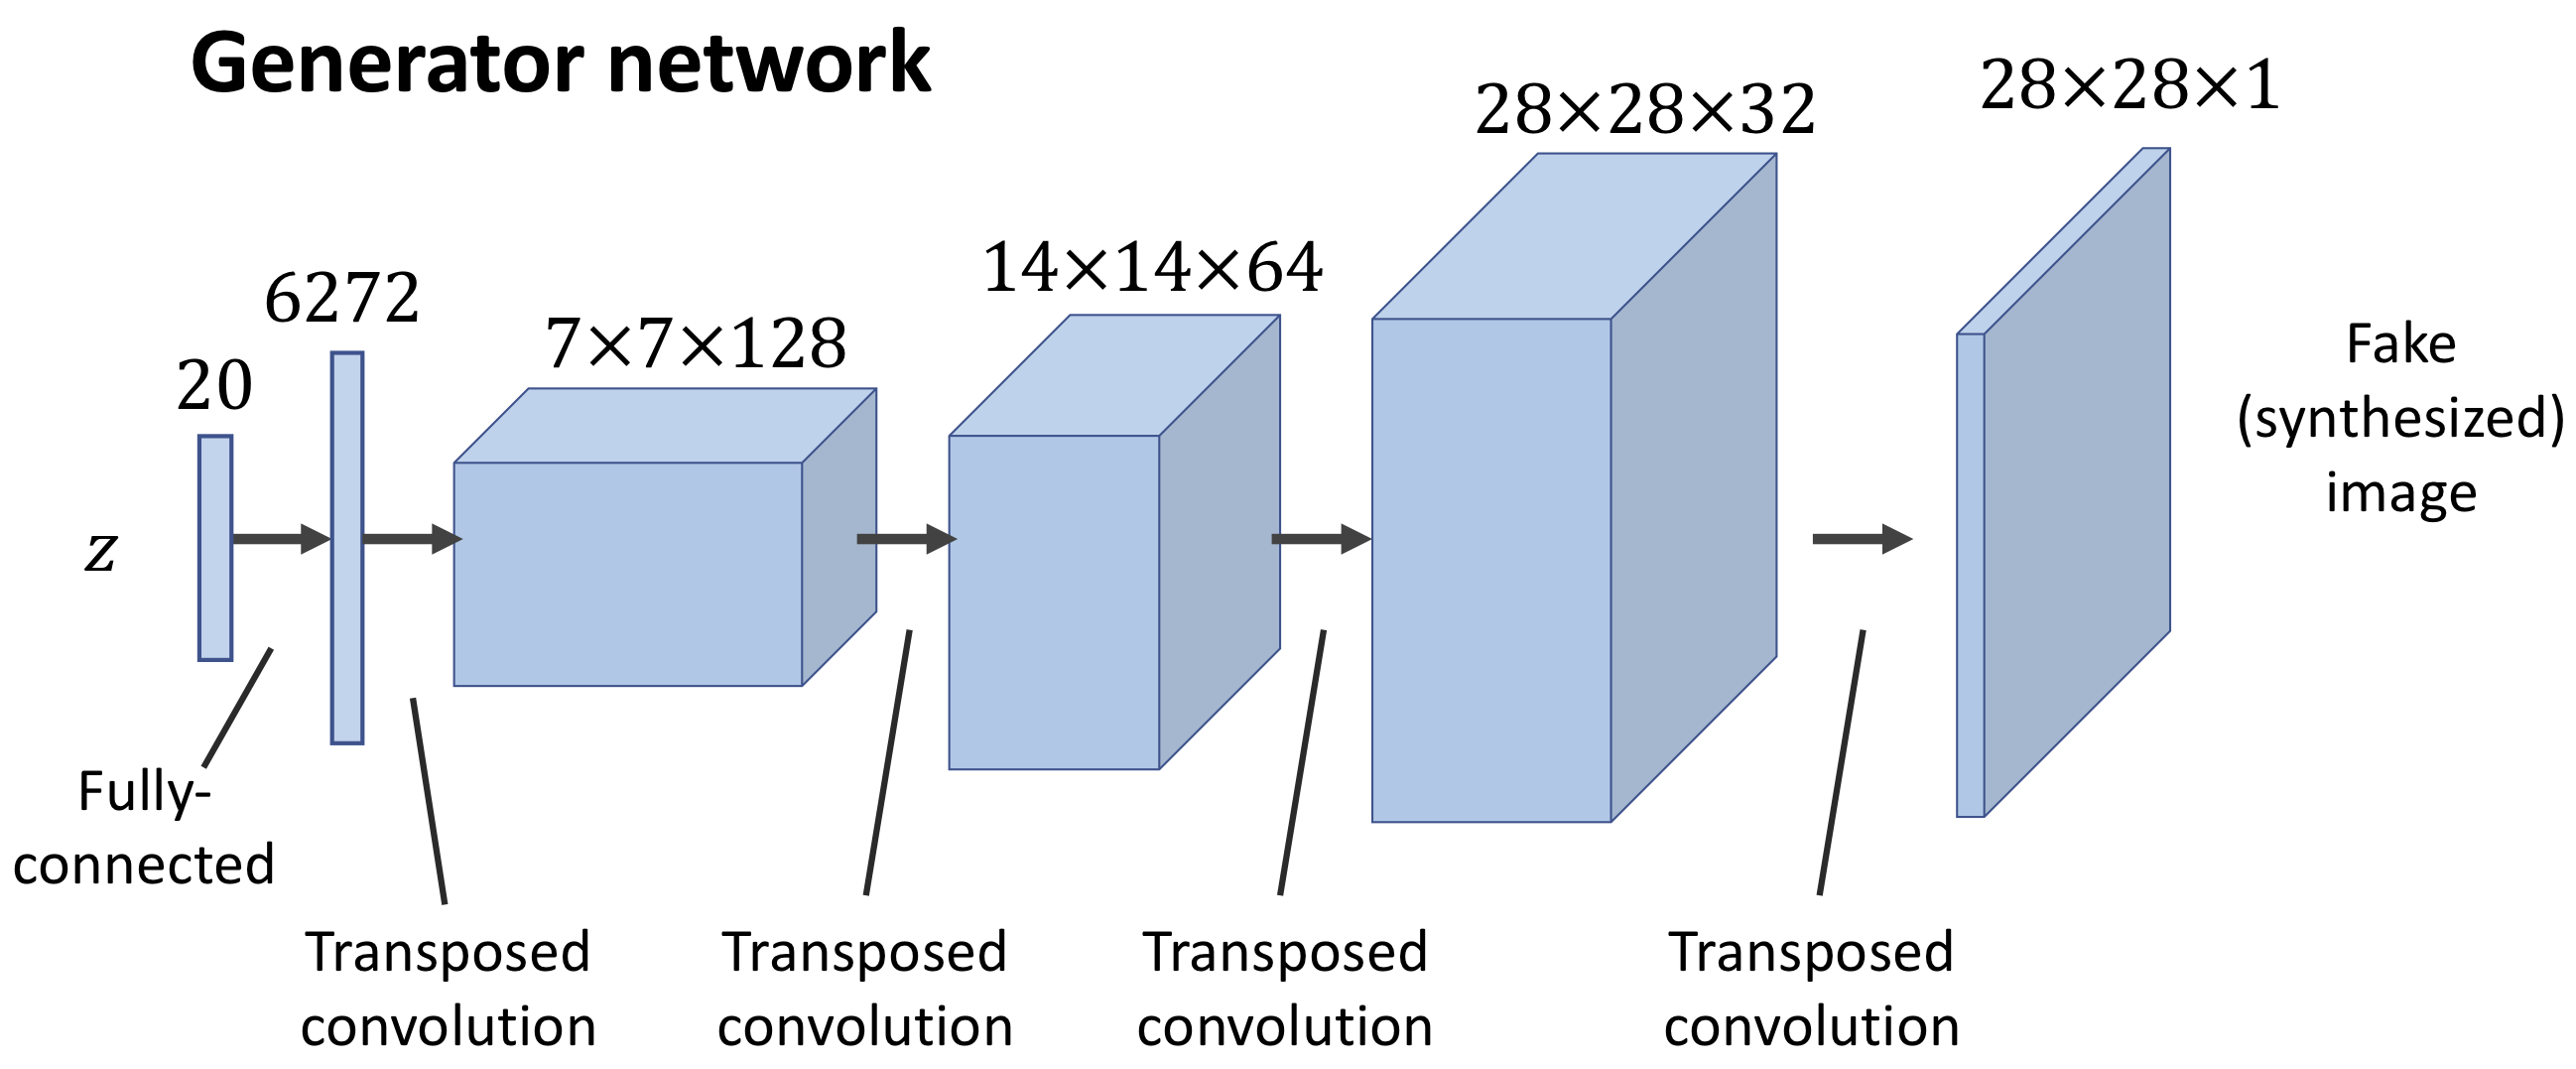

In [6]:
Image(filename='images/17_12.png', width=700)

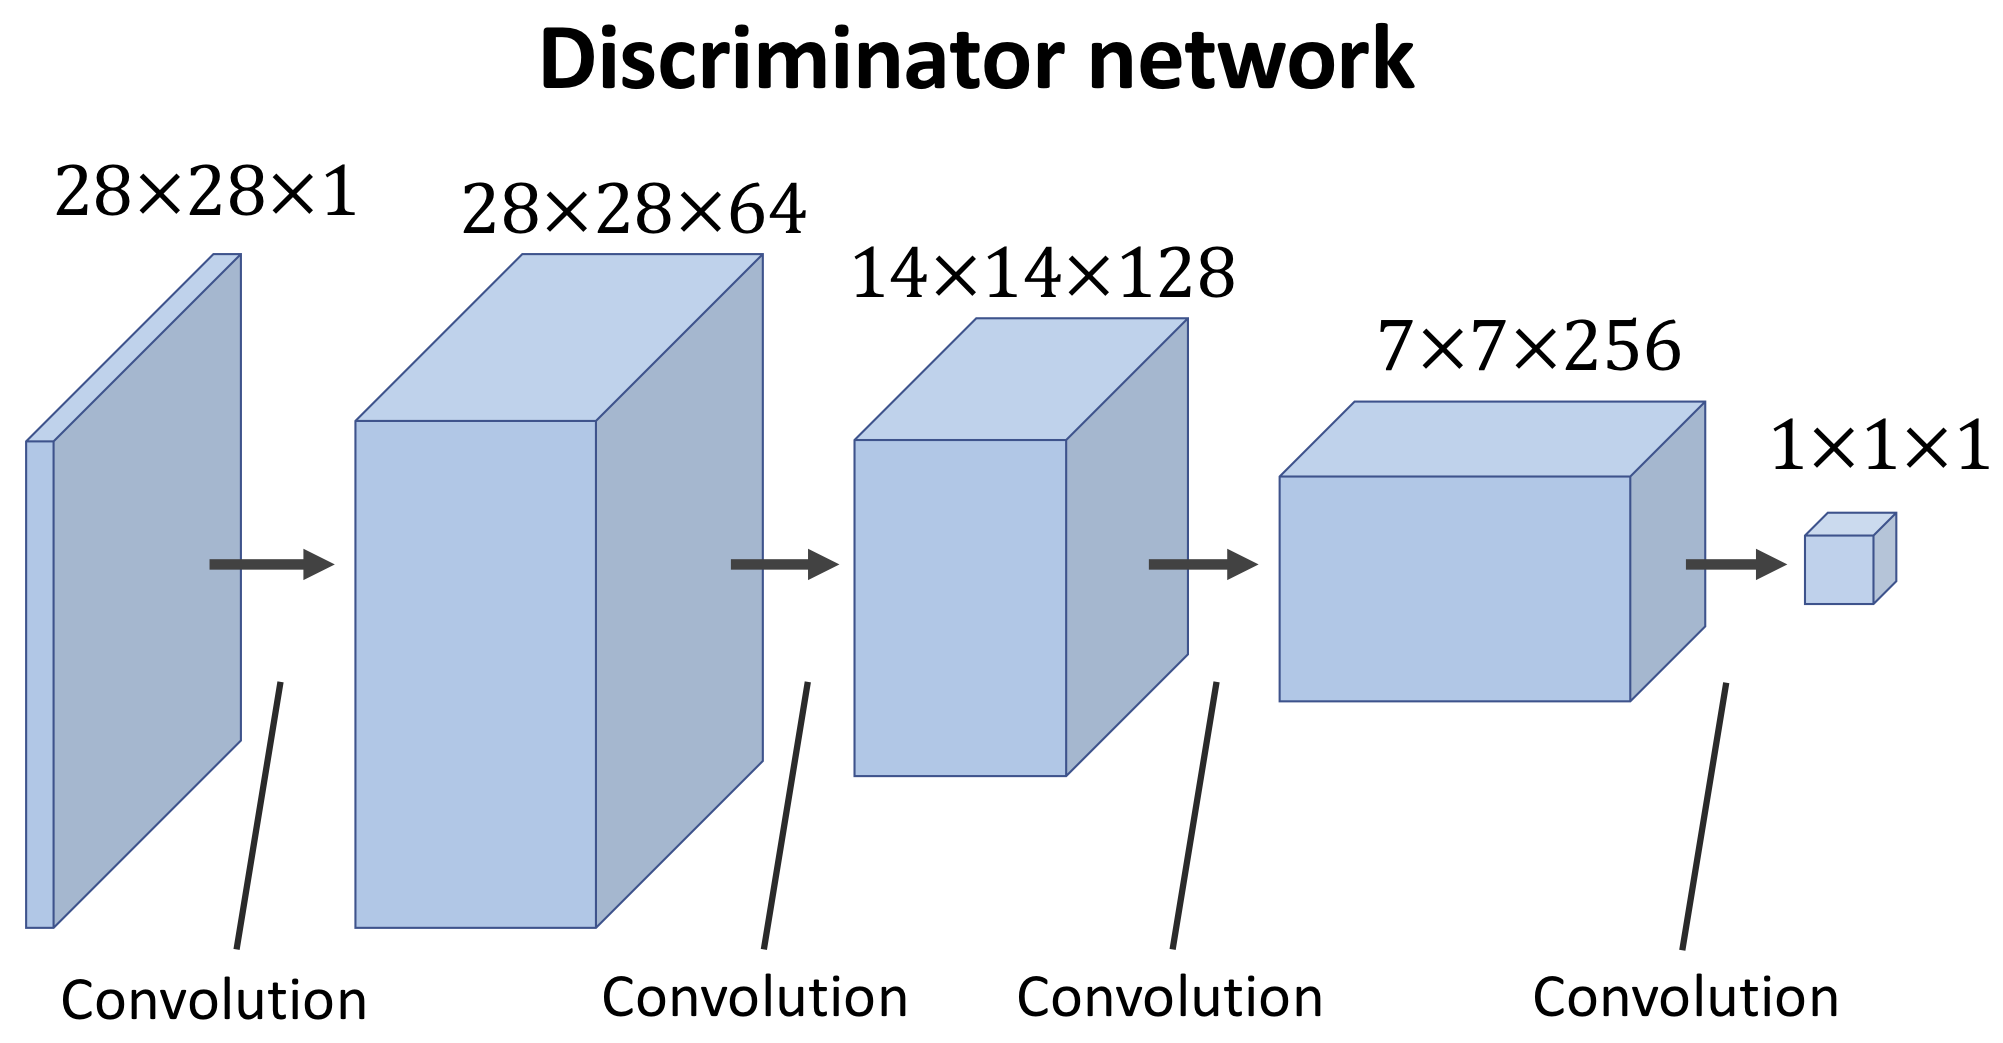

In [7]:
Image(filename='images/17_13.png', width=700)

 * **Setting up the Google Colab**

In [8]:
#! pip install -q tensorflow-gpu==2.0.0-beta1

In [9]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [10]:
import tensorflow as tf


print(tf.__version__)

print("GPU Available:", tf.test.is_gpu_available())

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()

else:
    device_name = 'CPU:0'
    
print(device_name)

2.0.0
GPU Available: True
/device:GPU:0


In [11]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def make_dcgan_generator(
        z_size=20, 
        output_size=(28, 28, 1),
        n_filters=128, 
        n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0]//size_factor, 
        output_size[1]//size_factor
    )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        
        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size), 
            use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),
    
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
        
    nf = n_filters
    for i in range(n_blocks):
        nf = nf // 2
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(5, 5), strides=(2, 2),
                padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
                
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5), 
            strides=(1, 1), padding='same', use_bias=False, 
            activation='tanh'))
        
    return model

def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=64, 
        n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5, 
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(5, 5), 
                strides=(2, 2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7), padding='valid'))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model

In [13]:
gen_model = make_dcgan_generator()
gen_model.summary()

disc_model = make_dcgan_discriminator()
disc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              125440    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

## Dissimilarity measures between two distributions 

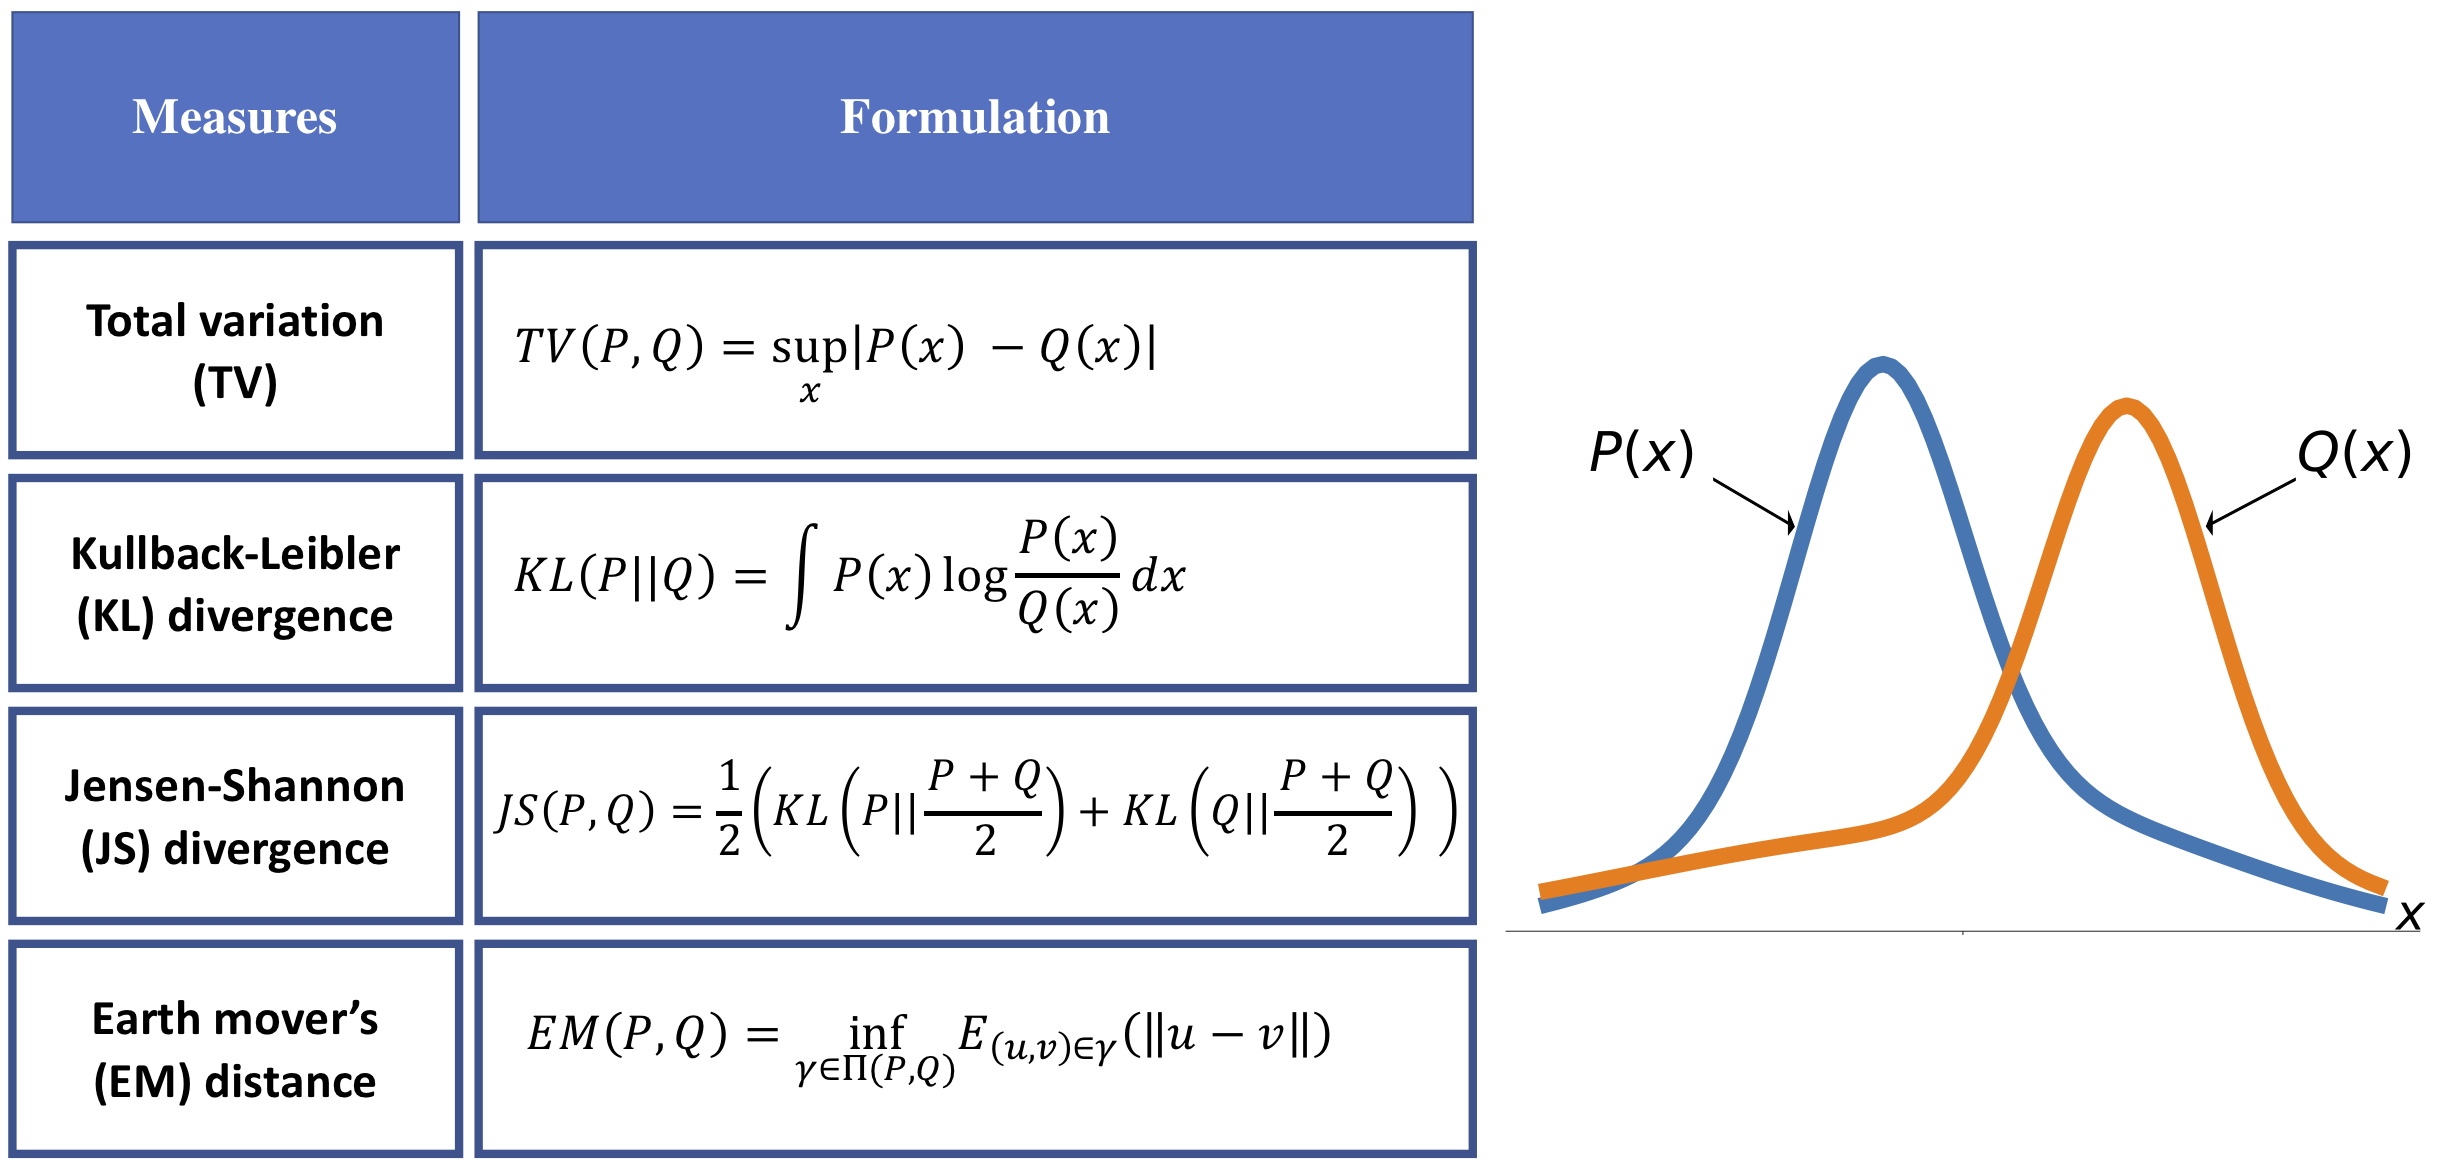

In [14]:
Image(filename='images/17_14.png', width=700)

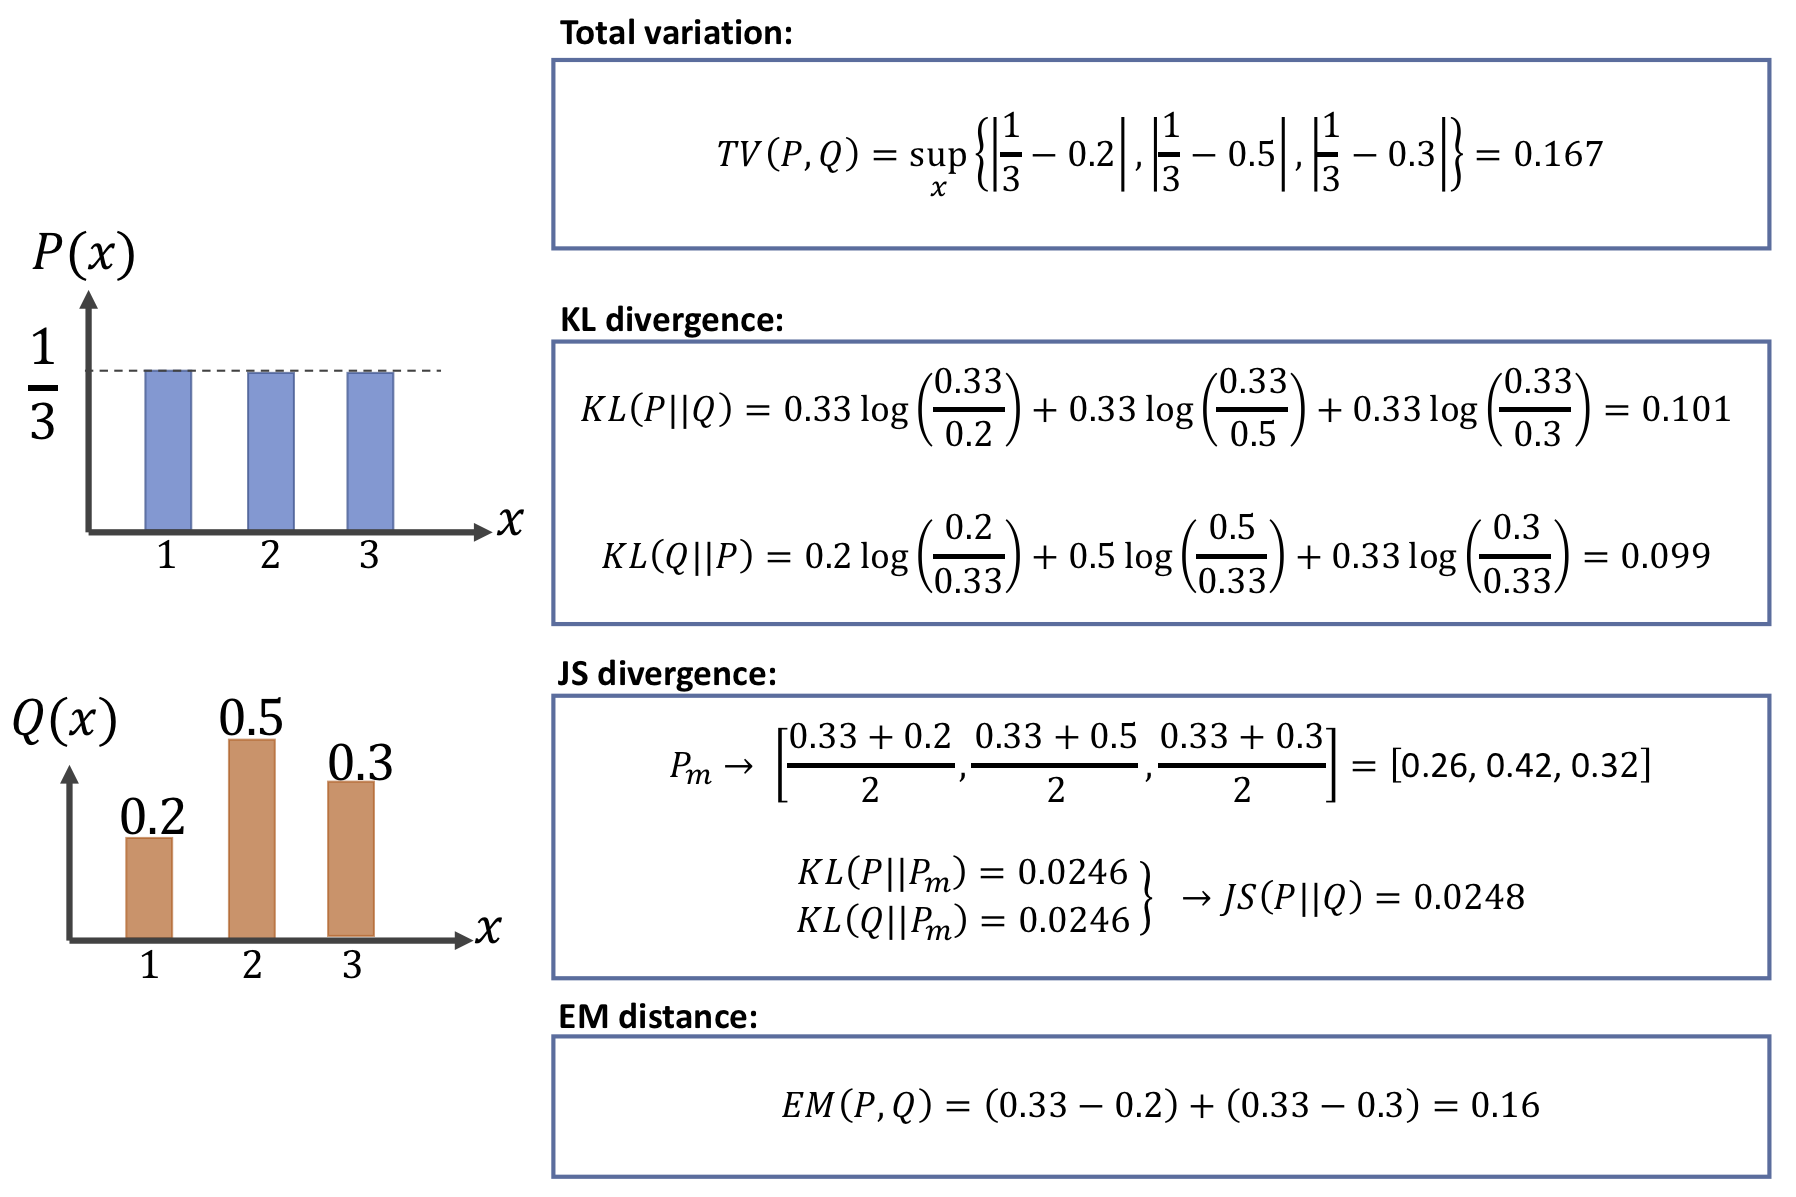

In [15]:
Image(filename='images/17_15.png', width=800)

## Using EM distance in practice for GANs

## Gradient penalty 

## Implementing WGAN-GP to train the DCGAN model

In [16]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

In [17]:
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device(device_name):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              125440    
_________________________________________________________________
batch_normalization_7 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)        

In [18]:
import time


## optimizers:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute discriminator's loss and gradients:
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            ## Compute generator's loss:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## Compute discriminator's losses
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            ## Gradient penalty:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + lambda_gp*grad_penalty
        
        ## Optimization: Compute the gradients apply them
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    
    print('Epoch {:-3d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f} D-Fake: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

Epoch   1 | ET 1.58 min | Avg Losses >> G/D 186.47/-305.89 [D-Real: -204.71 D-Fake: -186.47]
Epoch   2 | ET 3.17 min | Avg Losses >> G/D 125.83/-23.81 [D-Real: -88.27 D-Fake: -125.83]
Epoch   3 | ET 4.77 min | Avg Losses >> G/D  81.43/ -2.47 [D-Real:  29.42 D-Fake: -81.43]
Epoch   4 | ET 6.37 min | Avg Losses >> G/D  43.89/ -6.47 [D-Real: -14.41 D-Fake: -43.89]
Epoch   5 | ET 7.97 min | Avg Losses >> G/D  37.12/ -5.75 [D-Real:   4.77 D-Fake: -37.12]
Epoch   6 | ET 9.56 min | Avg Losses >> G/D  37.59/-10.89 [D-Real:  11.12 D-Fake: -37.59]
Epoch   7 | ET 11.16 min | Avg Losses >> G/D  48.30/-13.90 [D-Real:  32.22 D-Fake: -48.30]
Epoch   8 | ET 12.76 min | Avg Losses >> G/D  43.40/-20.73 [D-Real:  19.27 D-Fake: -43.40]
Epoch   9 | ET 14.36 min | Avg Losses >> G/D  51.94/-32.62 [D-Real:  10.19 D-Fake: -51.94]
Epoch  10 | ET 15.97 min | Avg Losses >> G/D  54.99/-34.56 [D-Real:  10.05 D-Fake: -54.99]
Epoch  11 | ET 17.57 min | Avg Losses >> G/D  78.72/-43.58 [D-Real:  21.09 D-Fake: -78.72]
E

In [19]:
#import pickle
#pickle.dump({'all_losses':all_losses, 
#             'samples':epoch_samples}, 
#            open('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-WDCGAN-learning.pkl', 'wb'))

#gen_model.save('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-WDCGAN-gan_gen.h5')
#disc_model.save('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-WDCGAN-gan_disc.h5')

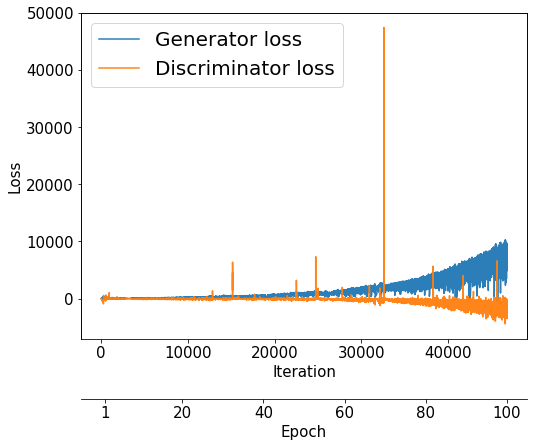

In [20]:
import itertools


fig = plt.figure(figsize=(8, 6))

## Plotting the losses
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

#plt.savefig('images/ch17-wdcgan-learning-curve.pdf')
plt.show()

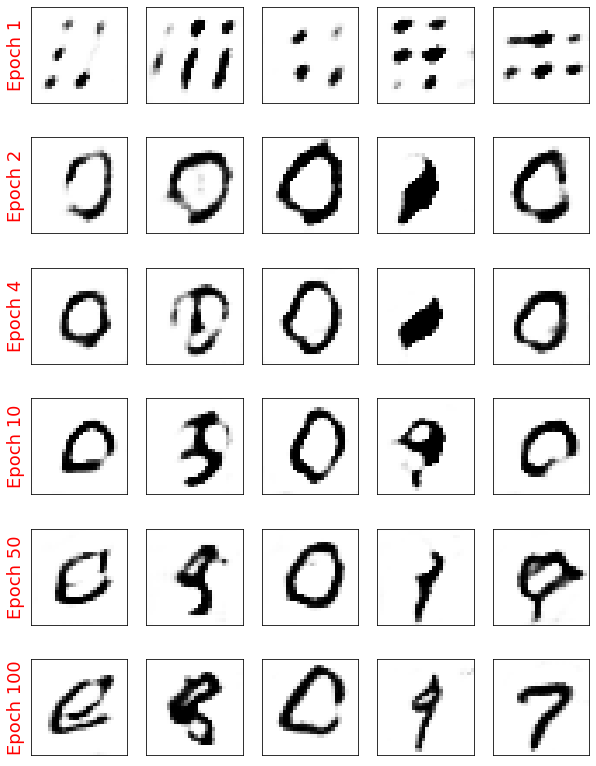

In [21]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
#plt.savefig('images/ch17-wdcgan-samples.pdf')
plt.show()

## Mode collapse

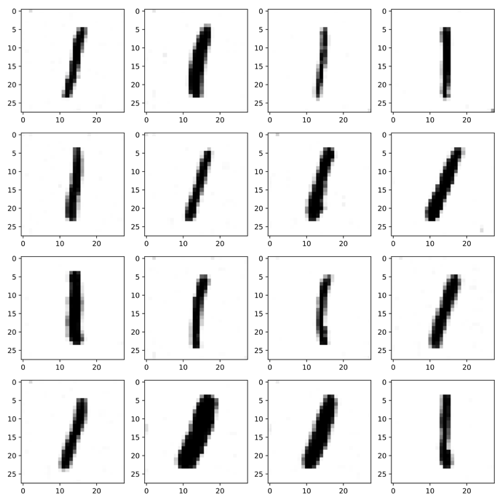

In [22]:
Image(filename='images/17_16.png', width=600)

<br>
<br>

----



Readers may ignore the next cell.



In [23]:
! python ../.convert_notebook_to_script.py --input ch17_part2.ipynb --output ch17_part2.py

[NbConvertApp] Converting notebook ch17_part2.ipynb to script
[NbConvertApp] Writing 11640 bytes to ch17_part2.py
